# Calculating SAM Using EOFs (Third Attempt)

This method is more closely related to the Simpson 2013 method.
- See this [notebook](/home/links/ct715/eddy_feedback/chapter1/annular_modes/old_scripts/sam_pc1_reanalysis.ipynb) for first attempt at calculations
- See this [notebook](/home/links/ct715/eddy_feedback/chapter1/annular_modes/old_scripts/reanalysis_simpson2013.ipynb) for first attempt at calculations

This document has improved methods for calculating SAM:
- THE CORRECT ORDER OF DOING THINGS

Eventual aim is reproduce this image:

[simpson2013](/home/links/ct715/eddy_feedback/chapter1/annular_modes/simpson2013_fig1.png)

SUCCESS!

In [1]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
from eofs.xarray import Eof
import xcdat

import functions.data_wrangling as dw
import annular_modes as am

In [2]:
def eof_calc_alt(data,lats):

    coslat = np.cos(np.deg2rad(lats.values)).clip(0., 1.)
    wgts = np.sqrt(coslat)[np.newaxis, np.newaxis, :]

    solver = Eof(data, weights=wgts, center=True)

    eofs = solver.eofsAsCovariance(neofs=1)
    pc1 = solver.pcs(npcs=1, pcscaling=1)

    variance_fractions = solver.varianceFraction(neigs=3)

    return eofs, pc1, variance_fractions, solver

In [3]:
path = '/home/links/ct715/data_storage/reanalysis/jra55_daily'
data_file = os.path.join(path, 'jra55_uvtw.nc')
ds = xr.open_mfdataset(data_file, chunks={'time': 30})
ds = ds.bounds.add_missing_bounds(axes='T')

ds_mon = ds.resample(time='1ME').mean(dim='time')
ds_mon['time'].encoding = ds['time'].encoding
ds_mon = ds_mon.bounds.add_missing_bounds(axes='T')

# Time period: 1958-2016

## All time

### Daily anomalies

In [23]:
# Compute EOFs, PCs, and variance fractions using the alternative EOF function
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_eofs_all-time_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_all = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds.temporal.departures(data_var='u', freq='day', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_all = xr.open_dataset(data_file)

Loading existing EOFs


In [ ]:
# Compute WEIGHTED EOFs, PCs, and variance fractions
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_eofs_all-time_va_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_all_va = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds.temporal.departures(data_var='u', freq='day', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    
    dp = var_anoms_hem.level.diff('level') 
    var_anoms_hem = (var_anoms_hem * dp).sum('level') / dp.sum('level')
    var_anoms_hem.name = 'u'
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_all_va = xr.open_dataset(data_file)

Computing EOFs and saving to /home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs/jra55_eofs_va_all-time_100-1000hPa.nc


KeyboardInterrupt: 

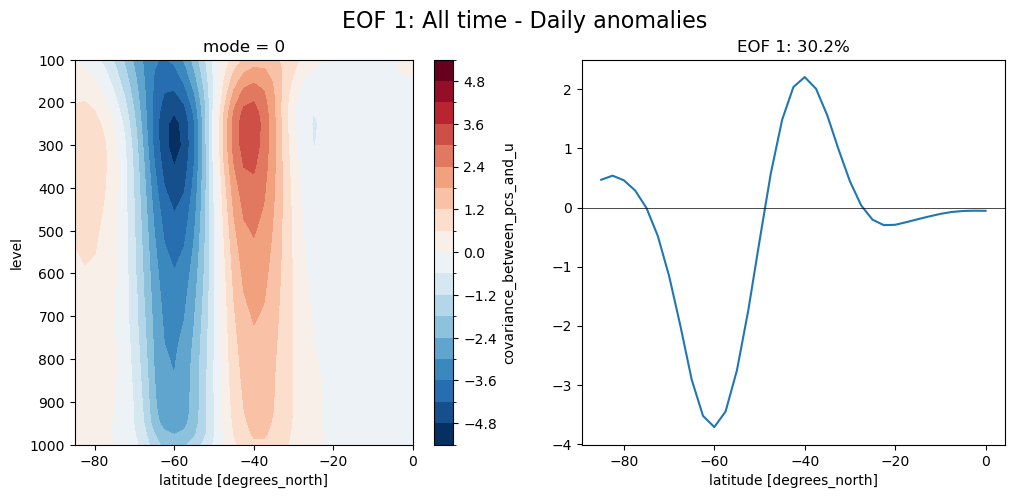

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12, 5))

eofs_all = eofs_ds_all['eofs']
eofs_all.sel(mode=0).plot.contourf(yincrease=False, levels=21, ax=ax1)
ax2.set_title(f"EOF 1: {eofs_ds_all['variance_fractions'][0].values*100:.1f}%")

wgt_avg = eofs_ds_all_va['eofs']
wgt_avg.sel(mode=0).plot.line(ax=ax2)
ax2.axhline(0, color='k', lw=0.5)
ax2.set_title(f"EOF 1: {eofs_ds_all_va['variance_fractions'][0].values*100:.1f}%")
fig.suptitle('EOF 1: All time - Daily anomalies', fontsize=16)
plt.show()

### Monthly anomalies (all time)

In [4]:
# Compute EOFs, PCs, and variance fractions using the alternative EOF function
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_eofs_all-time_mon_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_all_mon = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds_mon.temporal.departures(data_var='u', freq='month', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_all_mon = xr.open_dataset(data_file)

Loading existing EOFs


In [ ]:
# Compute WEIGHTED EOFs, PCs, and variance fractions
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_eofs_all-time_mon_va_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_all_mon_va = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds_mon.temporal.departures(data_var='u', freq='month', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    
    dp = var_anoms_hem.level.diff('level') 
    var_anoms_hem = (var_anoms_hem * dp).sum('level') / dp.sum('level')
    var_anoms_hem.name = 'u'
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_all_mon_va = xr.open_dataset(data_file)

Computing EOFs and saving to /home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs/jra55_eofs_all-time_va_mon_100-1000hPa.nc


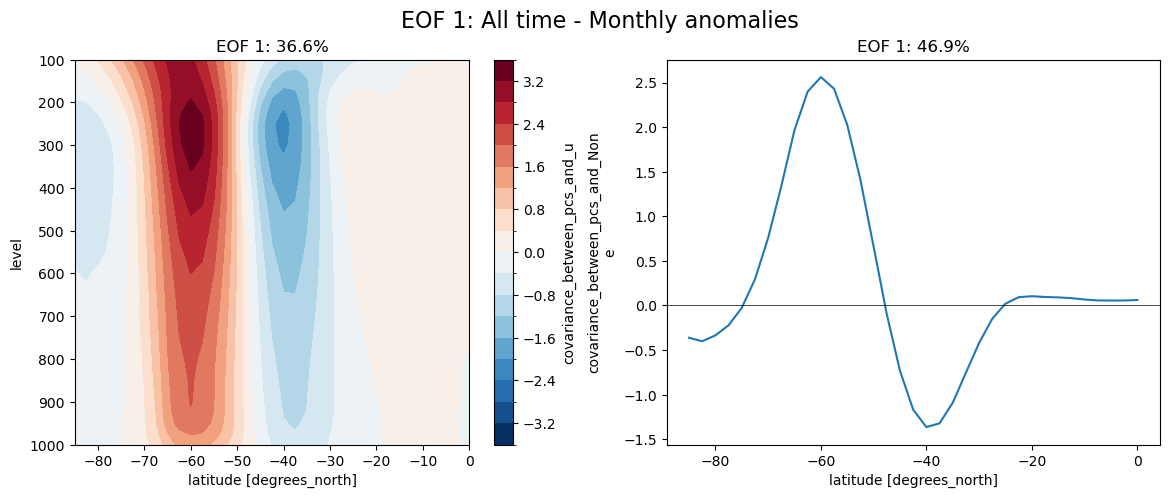

In [9]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14, 5))

eofs_all = eofs_ds_all_mon['eofs']
eofs_all.sel(mode=0).plot.contourf(yincrease=False, levels=21, ax=ax1)
ax1.set_title(f"EOF 1: {eofs_ds_all_mon['variance_fractions'][0].values*100:.1f}%")

wgt_avg = eofs_ds_all_mon_va['eofs']
wgt_avg.sel(mode=0).plot.line(ax=ax2)
ax2.axhline(0, color='k', lw=0.5)
ax2.set_title(f"EOF 1: {eofs_ds_all_mon_va['variance_fractions'][0].values*100:.1f}%")
fig.suptitle('EOF 1: All time - Monthly anomalies', fontsize=16)
plt.show()

## SH Winter (JJA)

### Daily anoms

In [ ]:
# Compute EOFs, PCs, and variance fractions using the alternative EOF function
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_eofs_jja_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_jja = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds.temporal.departures(data_var='u', freq='season', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    var_anoms_hem = var_anoms_hem.sel(time=var_anoms_hem.time.dt.month.isin([7]))
    print('Anoms calculated, now EOFS...')
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    print('EOFs calculated. Now saving...')
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_jja = xr.open_dataset(data_file)

Loading existing EOFs


In [ ]:
# Compute WEIGHTED EOFs, PCs, and variance fractions
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_eofs_jja_va_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_jja_va = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds.temporal.departures(data_var='u', freq='season', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    
    dp = var_anoms_hem.level.diff('level') 
    var_anoms_hem = (var_anoms_hem * dp).sum('level') / dp.sum('level')
    var_anoms_hem.name = 'u'
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_jja_va = xr.open_dataset(data_file)

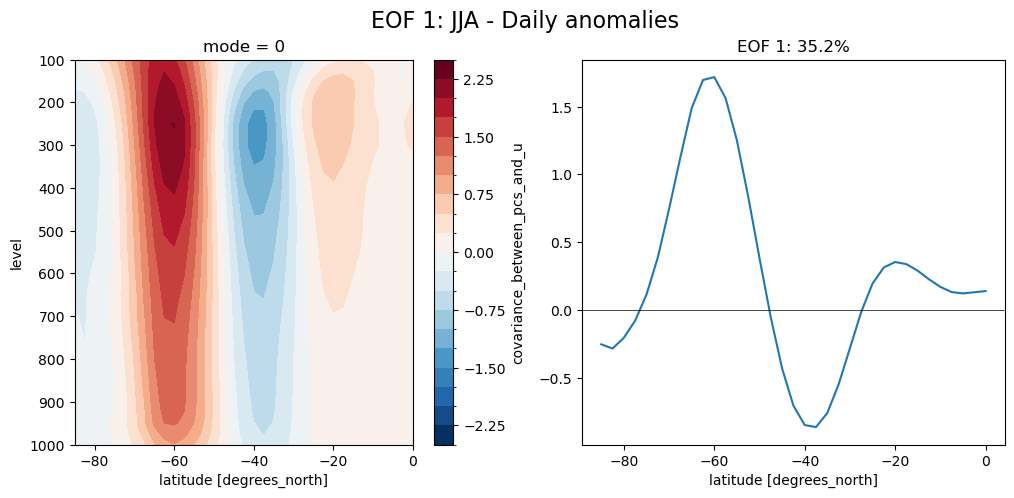

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12, 5))

eofs_sh = eofs_ds_jja['eofs']
eofs_sh.sel(mode=0).plot.contourf(yincrease=False, levels=21, ax=ax1)
ax1.set_title(f"EOF 1: {eofs_ds_jja['variance_fractions'][0].values*100:.1f}%")

wgt_avg = eofs_ds_jja_va['eofs']
wgt_avg.sel(mode=0).plot.line(ax=ax2)
ax2.axhline(0, color='k', lw=0.5)
ax2.set_title(f"EOF 1: {eofs_ds_jja_va['variance_fractions'][0].values*100:.1f}%")
fig.suptitle('EOF 1: JJA - Daily anomalies', fontsize=16)
plt.show()

### Monthly anoms (JJA)

In [10]:
# Compute EOFs, PCs, and variance fractions using the alternative EOF function
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_eofs_jja_mon_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_jja_mon = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds_mon.temporal.departures(data_var='u', freq='season', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    var_anoms_hem = var_anoms_hem.sel(time=var_anoms_hem.time.dt.month.isin([7]))
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_jja_mon = xr.open_dataset(data_file)

Loading existing EOFs


In [ ]:
# Compute WEIGHTED EOFs, PCs, and variance fractions
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_eofs_jja_mon_va_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_jja_mon_va = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds_mon.temporal.departures(data_var='u', freq='season', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    
    dp = var_anoms_hem.level.diff('level') 
    var_anoms_hem = (var_anoms_hem * dp).sum('level') / dp.sum('level')
    var_anoms_hem.name = 'u'
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_jja_mon_va = xr.open_dataset(data_file)

Computing EOFs and saving to /home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs/jra55_eofs_jja_va_mon_100-1000hPa.nc


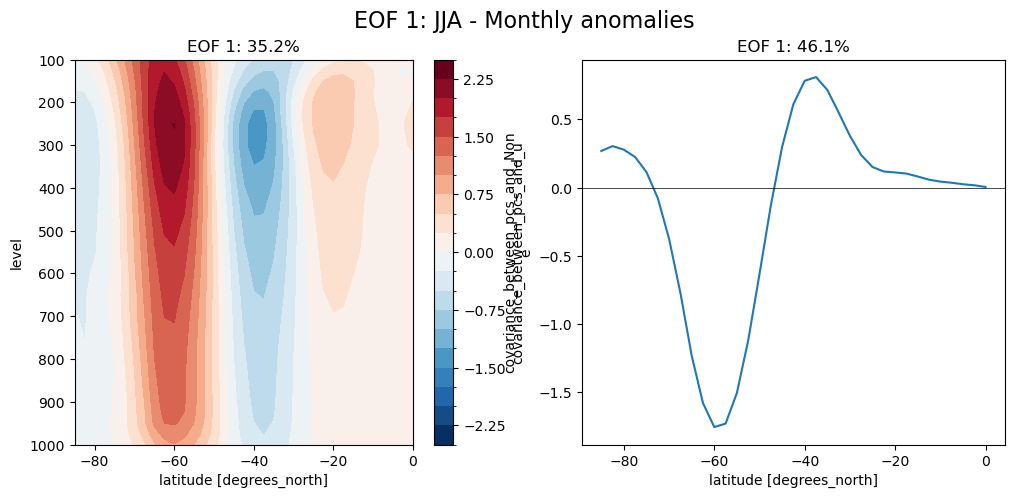

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14, 5))

eofs_sh = eofs_ds_jja_mon['eofs']
eofs_sh.sel(mode=0).plot.contourf(yincrease=False, levels=21, ax=ax1)
ax1.set_title(f"EOF 1: {eofs_ds_jja_mon['variance_fractions'][0].values*100:.1f}%")

wgt_avg = eofs_ds_jja_mon_va['eofs']
wgt_avg.sel(mode=0).plot.line(ax=ax2)
ax2.axhline(0, color='k', lw=0.5)
ax2.set_title(f"EOF 1: {eofs_ds_jja_mon_va['variance_fractions'][0].values*100:.1f}%")
fig.suptitle('EOF 1: JJA - Monthly anomalies', fontsize=16)
plt.show()

### JJA monthly anomalies without `xcdat`

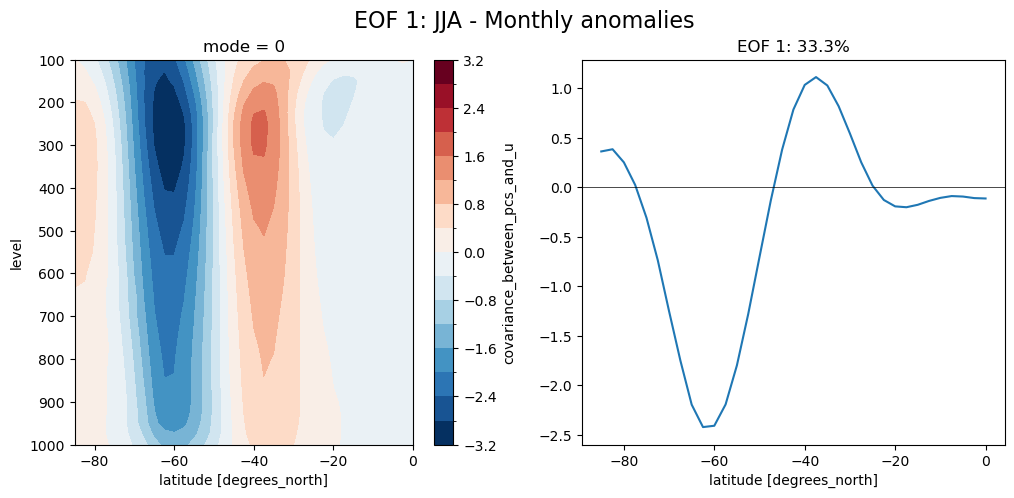

In [31]:
# Compute the JJA monthly climatology for each calendar month
jja = ds_mon.sel(time=ds_mon.time.dt.month.isin([6, 7, 8]))
climatology = jja['u'].groupby('time.month').mean(dim='time')

# Subtract monthly climatology to get anomalies
anomalies = jja['u'].groupby('time.month') - climatology

# take zonal mean and subset data
var_anoms = anomalies.mean(dim='lon')
var_anoms_hem = var_anoms.sel(lat=slice(0, -85), level=slice(100, 1000))
var_anoms_hem = var_anoms_hem.sel(time=var_anoms_hem.time.dt.month.isin([6, 7, 8]))

# compute EOFs
eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)

# plot it
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12, 5))

eofs.sel(mode=0).plot.contourf(yincrease=False, levels=21, ax=ax1)

dp = eofs.level.diff('level')
wgt_avg = (eofs * dp).sum('level') / dp.sum('level')
wgt_avg.sel(mode=0).plot.line(ax=ax2)
ax2.axhline(0, color='k', lw=0.5)
ax2.set_title(f"EOF 1: {variance_fractions[0].values*100:.1f}%")
fig.suptitle('EOF 1: JJA - Monthly anomalies', fontsize=16)
plt.show()

## SH Summer (DJF)

### Daily anoms

In [32]:
# Compute EOFs, PCs, and variance fractions using the alternative EOF function
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_eofs_djf_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_djf = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds.temporal.departures(data_var='u', freq='season', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    var_anoms_hem = var_anoms_hem.sel(time=var_anoms_hem.time.dt.month.isin([1]))
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_djf = xr.open_dataset(data_file)

Computing EOFs and saving to /home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs/jra55_eofs_djf_100-1000hPa.nc


In [ ]:
# Compute WEIGHTED EOFs, PCs, and variance fractions
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_eofs_djf_va_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_djf_va = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds.temporal.departures(data_var='u', freq='season', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    
    dp = var_anoms_hem.level.diff('level') 
    var_anoms_hem = (var_anoms_hem * dp).sum('level') / dp.sum('level')
    var_anoms_hem.name = 'u'
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_djf_va = xr.open_dataset(data_file)

Text(0.5, 1.0, 'EOF 1: 42.7%')

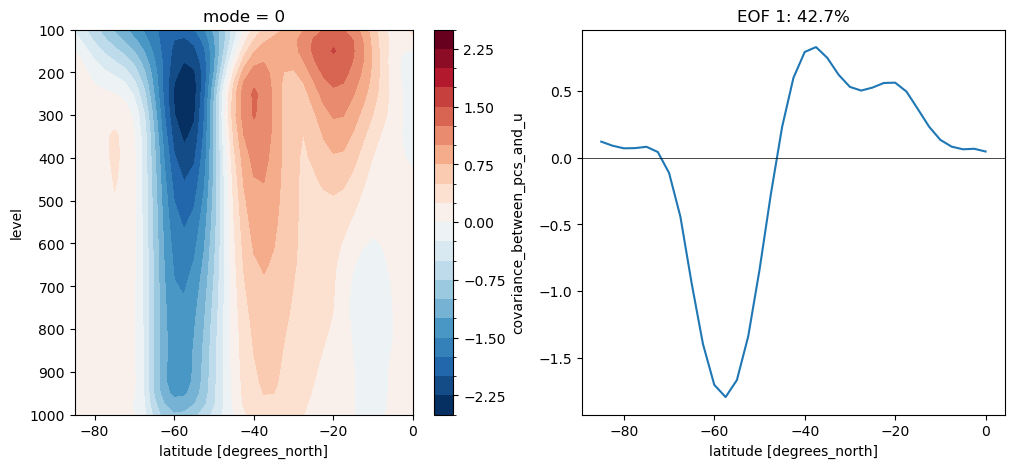

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14, 5))

eofs_djf = eofs_ds_djf['eofs']
eofs_djf.sel(mode=0).plot.contourf(yincrease=False, levels=21, ax=ax1)

wgt_avg = eofs_ds_djf_va['eofs']
wgt_avg.sel(mode=0).plot.line(ax=ax2)
ax2.axhline(0, color='k', lw=0.5)
ax2.set_title(f"EOF 1: {eofs_ds_djf['variance_fractions'][0].values*100:.1f}%")

### Monthly SH Summer (DJF)

In [13]:
# Compute EOFs, PCs, and variance fractions using the alternative EOF function
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_eofs_djf_mon_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_djf_mon = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds_mon.temporal.departures(data_var='u', freq='season', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    var_anoms_hem = var_anoms_hem.sel(time=var_anoms_hem.time.dt.month.isin([1]))
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_djf_mon = xr.open_dataset(data_file)

Loading existing EOFs


In [ ]:
# Compute WEIGHTED EOFs, PCs, and variance fractions
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_eofs_djf_mon_va_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_djf_mon_va = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds_mon.temporal.departures(data_var='u', freq='season', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    
    dp = var_anoms_hem.level.diff('level') 
    var_anoms_hem = (var_anoms_hem * dp).sum('level') / dp.sum('level')
    var_anoms_hem.name = 'u'
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_djf_mon_va = xr.open_dataset(data_file)

Computing EOFs and saving to /home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs/jra55_eofs_djf_va_mon_100-1000hPa.nc


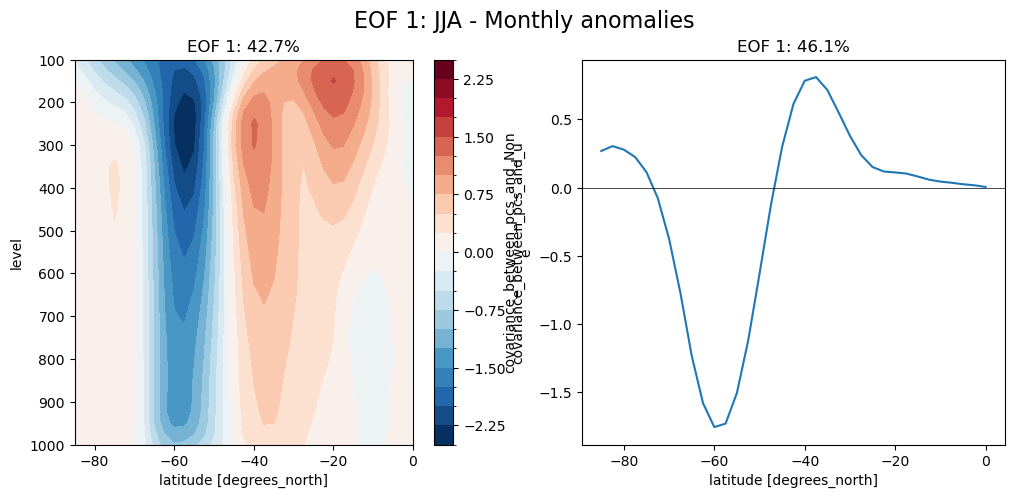

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14, 5))

eofs_sh = eofs_ds_djf_mon['eofs']
eofs_sh.sel(mode=0).plot.contourf(yincrease=False, levels=21, ax=ax1)
ax1.set_title(f"EOF 1: {eofs_ds_djf_mon['variance_fractions'][0].values*100:.1f}%")

wgt_avg = eofs_ds_djf_mon_va['eofs']
wgt_avg.sel(mode=0).plot.line(ax=ax2)
ax2.axhline(0, color='k', lw=0.5)
ax2.set_title(f"EOF 1: {eofs_ds_djf_mon_va['variance_fractions'][0].values*100:.1f}%")
fig.suptitle('EOF 1: JJA - Monthly anomalies', fontsize=16)
plt.show()

# Time period: 1979-2010

## All time daily anomalies

In [16]:
ds79 = ds.sel(time=slice('1979-01-01', '2010-12-31'))

In [ ]:
# Compute EOFs, PCs, and variance fractions using the alternative EOF function
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_1979-2010_eofs_all-time_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_all79 = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds79.temporal.departures(data_var='u', freq='day', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_all79 = xr.open_dataset(data_file)

Loading existing EOFs


In [ ]:
# Compute WEIGHTED EOFs, PCs, and variance fractions
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_1979-2010_eofs_all-time_va_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_all79_va = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds79.temporal.departures(data_var='u', freq='day', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    
    dp = var_anoms_hem.level.diff('level') 
    var_anoms_hem = (var_anoms_hem * dp).sum('level') / dp.sum('level')
    var_anoms_hem.name = 'u'
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_all79_va = xr.open_dataset(data_file)

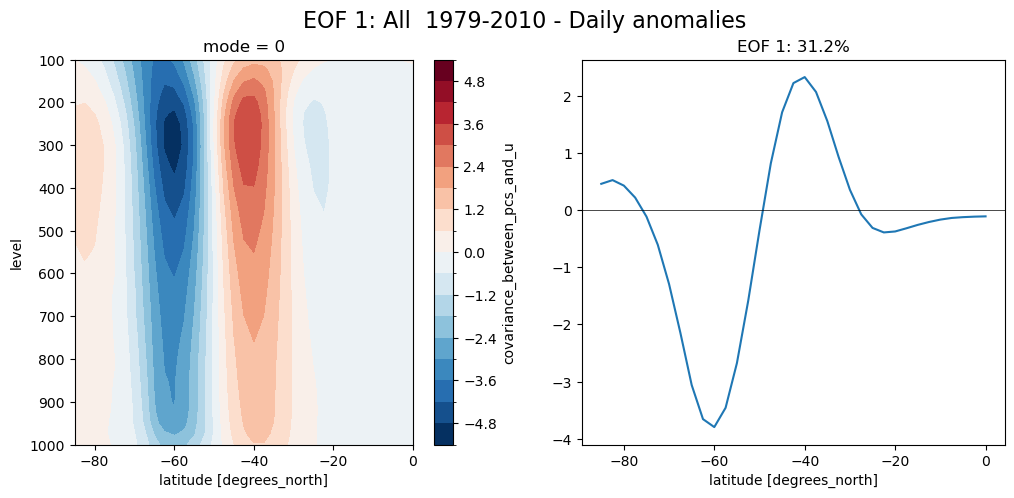

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14, 5))

eofs_all = eofs_ds_all79['eofs']
eofs_all.sel(mode=0).plot.contourf(yincrease=False, levels=21, ax=ax1)
ax1.set_title(f"EOF 1: {eofs_ds_all79['variance_fractions'][0].values*100:.1f}%")

wgt_avg = eofs_ds_all79_va['eofs']
wgt_avg.sel(mode=0).plot.line(ax=ax2)
ax2.axhline(0, color='k', lw=0.5)
ax2.set_title(f"EOF 1: {eofs_ds_all79_va['variance_fractions'][0].values*100:.1f}%")
fig.suptitle('EOF 1: All time 1979-2010 - Daily anomalies', fontsize=16)
plt.show()

## Deasonalised all time (?)

In [ ]:
# Compute EOFs, PCs, and variance fractions using the alternative EOF function
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_1979-2010_eofs_deseason_all-time_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_all79_deseason = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds79.temporal.departures(data_var='u', freq='season', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_all79_deseason = xr.open_dataset(data_file)

Computing EOFs and saving to /home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs/jra55_1979-2010_eofs_deseason_all-time_100-1000hPa.nc


In [ ]:
# Compute WEIGHTED EOFs, PCs, and variance fractions
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_eofs_deseason_all-time_va_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_all79_va_deseason = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds79.temporal.departures(data_var='u', freq='season', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    
    dp = var_anoms_hem.level.diff('level') 
    var_anoms_hem = (var_anoms_hem * dp).sum('level') / dp.sum('level')
    var_anoms_hem.name = 'u'
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_all79_va_deseason = xr.open_dataset(data_file)

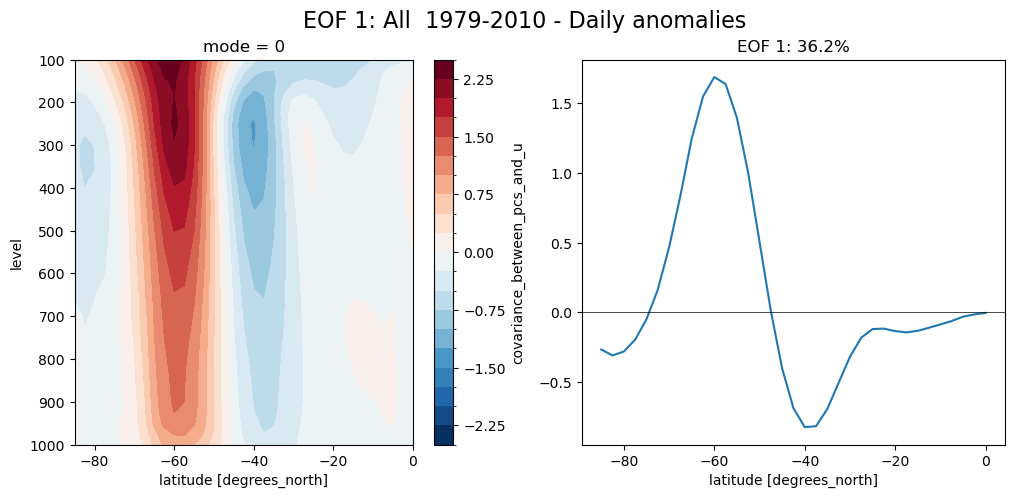

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14, 5))

eofs_all = eofs_ds_all79_deseason['eofs']
eofs_all.sel(mode=0).plot.contourf(yincrease=False, levels=21, ax=ax1)
ax1.set_title(f"EOF 1: {eofs_ds_all79_deseason['variance_fractions'][0].values*100:.1f}%")

wgt_avg = eofs_ds_all79_va_deseason['eofs']
wgt_avg.sel(mode=0).plot.line(ax=ax2)
ax2.axhline(0, color='k', lw=0.5)
ax2.set_title(f"EOF 1: {eofs_ds_all79_va_deseason['variance_fractions'][0].values*100:.1f}%")
fig.suptitle('EOF 1: All time (deseasonalised) 1979-2010 - Daily anomalies', fontsize=16)
plt.show()

## All time monthly anomalies

In [17]:
ds_mon79 = ds_mon.sel(time=slice('1979-01-01', '2010-12-31'))

In [18]:
# Compute EOFs, PCs, and variance fractions using the alternative EOF function
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_1979-2010_eofs_all-time_mon_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_all79_mon = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds_mon79.temporal.departures(data_var='u', freq='month', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_all79_mon = xr.open_dataset(data_file)

Loading existing EOFs


In [ ]:
# Compute WEIGHTED EOFs, PCs, and variance fractions
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_1979-2010_eofs_all-time_mon_va_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_all79_mon_va = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds_mon79.temporal.departures(data_var='u', freq='month', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    
    dp = var_anoms_hem.level.diff('level') 
    var_anoms_hem = (var_anoms_hem * dp).sum('level') / dp.sum('level')
    var_anoms_hem.name = 'u'
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_all79_mon_va = xr.open_dataset(data_file)

Computing EOFs and saving to /home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs/jra55_1979-2010_eofs_all-time_va_mon_100-1000hPa.nc


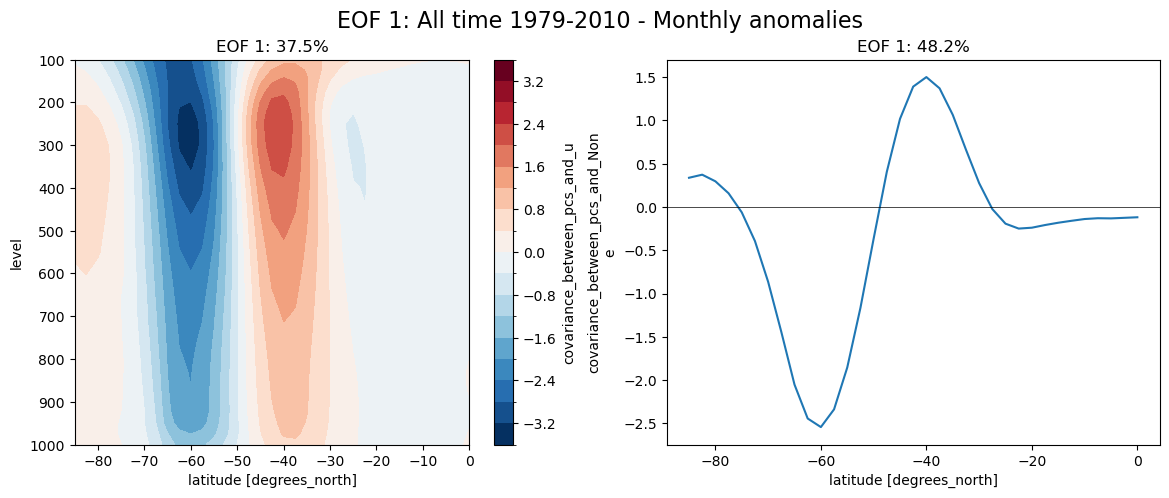

In [20]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14, 5))

eofs_all = eofs_ds_all79_mon['eofs']
eofs_all.sel(mode=0).plot.contourf(yincrease=False, levels=21, ax=ax1)
ax1.set_title(f"EOF 1: {eofs_ds_all79_mon['variance_fractions'][0].values*100:.1f}%")

wgt_avg = eofs_ds_all79_mon_va['eofs']
wgt_avg.sel(mode=0).plot.line(ax=ax2)
ax2.axhline(0, color='k', lw=0.5)
ax2.set_title(f"EOF 1: {eofs_ds_all79_mon_va['variance_fractions'][0].values*100:.1f}%")
fig.suptitle('EOF 1: All time 1979-2010 - Monthly anomalies', fontsize=16)
plt.show()

## Monthly anoms (JJA)

In [21]:
# Compute EOFs, PCs, and variance fractions using the alternative EOF function
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_1979-2010_eofs_jja_mon_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_jja79_mon = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds_mon79.temporal.departures(data_var='u', freq='season', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    var_anoms_hem = var_anoms_hem.sel(time=var_anoms_hem.time.dt.month.isin([7]))
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_jja79_mon = xr.open_dataset(data_file)

Loading existing EOFs


In [ ]:
# Compute WEIGHTED EOFs, PCs, and variance fractions
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_1979-2010_eofs_jja_mon_va_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_jja79_mon_va = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds_mon79.temporal.departures(data_var='u', freq='season', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    
    dp = var_anoms_hem.level.diff('level') 
    var_anoms_hem = (var_anoms_hem * dp).sum('level') / dp.sum('level')
    var_anoms_hem.name = 'u'
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_jja79_mon_va = xr.open_dataset(data_file)

Computing EOFs and saving to /home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs/jra55_1979-2010_eofs_jja_va_mon_100-1000hPa.nc


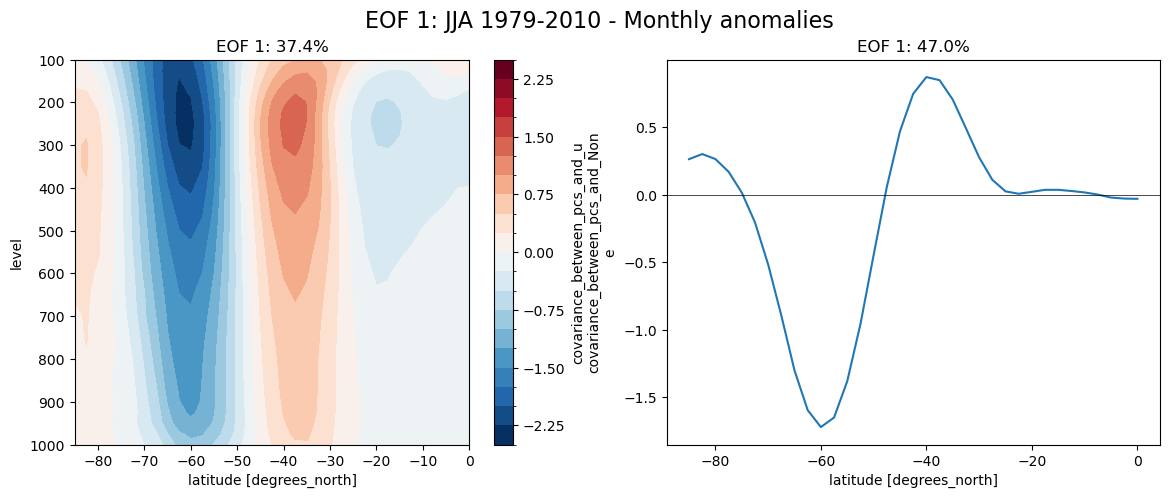

In [23]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14, 5))

eofs_sh = eofs_ds_jja79_mon['eofs']
eofs_sh.sel(mode=0).plot.contourf(yincrease=False, levels=21, ax=ax1)
ax1.set_title(f"EOF 1: {eofs_ds_jja79_mon['variance_fractions'][0].values*100:.1f}%")

wgt_avg = eofs_ds_jja79_mon_va['eofs']
wgt_avg.sel(mode=0).plot.line(ax=ax2)
ax2.axhline(0, color='k', lw=0.5)
ax2.set_title(f"EOF 1: {eofs_ds_jja79_mon_va['variance_fractions'][0].values*100:.1f}%")
fig.suptitle('EOF 1: JJA 1979-2010 - Monthly anomalies', fontsize=16)
plt.show()

## Monthly SH Summer (DJF)

In [24]:
# Compute EOFs, PCs, and variance fractions using the alternative EOF function
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_1979-2010_eofs_djf_mon_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_djf79_mon = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds_mon79.temporal.departures(data_var='u', freq='season', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    var_anoms_hem = var_anoms_hem.sel(time=var_anoms_hem.time.dt.month.isin([1]))
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_djf79_mon = xr.open_dataset(data_file)

Loading existing EOFs


In [ ]:
# Compute WEIGHTED EOFs, PCs, and variance fractions
save_data_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs'
data_file_name = 'jra55_1979-2010_eofs_djf_mon_va_100-1000hPa.nc'
data_file = os.path.join(save_data_path, data_file_name)
if os.path.isfile(data_file):
    print('Loading existing EOFs')
    eofs_ds_djf79_mon_va = xr.open_dataset(data_file)
else:
    print(f'Computing EOFs and saving to {data_file}')
    var_anoms = ds_mon79.temporal.departures(data_var='u', freq='season', weighted=True)['u'].mean('lon')
    var_anoms_hem = var_anoms.sel(lat=slice(0,-85)).sel(level=slice(100,1000))
    
    dp = var_anoms_hem.level.diff('level') 
    var_anoms_hem = (var_anoms_hem * dp).sum('level') / dp.sum('level')
    var_anoms_hem.name = 'u'
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)
    
    eofs_ds = xr.Dataset(coords=eofs.coords)
    eofs_ds['eofs'] = eofs
    eofs_ds['pc1'] = pc1
    eofs_ds['variance_fractions'] = variance_fractions
    eofs_ds.to_netcdf(data_file)
    eofs_ds.close()
    eofs_ds_djf79_mon_va = xr.open_dataset(data_file)

Computing EOFs and saving to /home/links/ct715/eddy_feedback/chapter1/annular_modes/data/eofs/jra55_1979-2010_eofs_djf_mon_va_100-1000hPa.nc


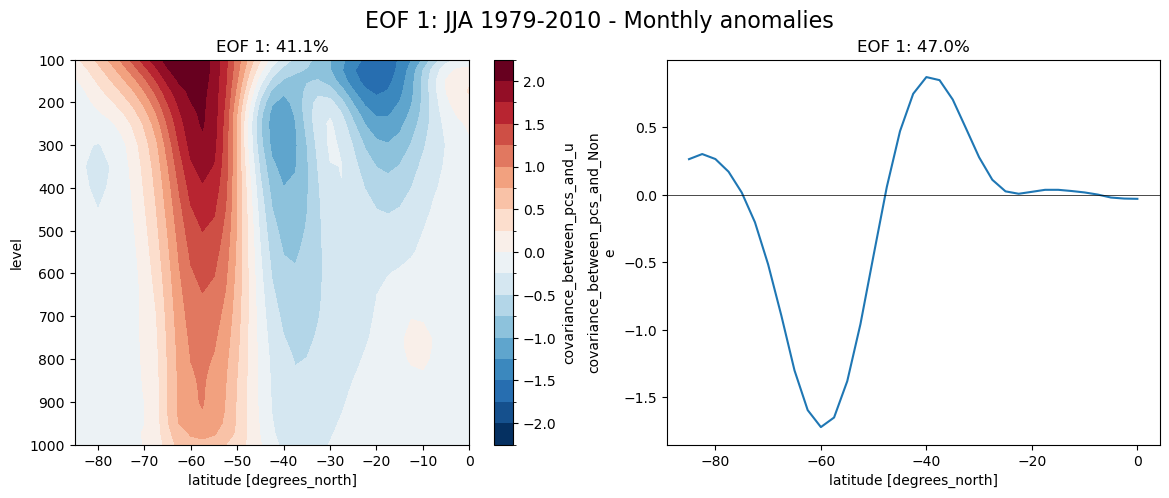

In [26]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14, 5))

eofs_sh = eofs_ds_djf79_mon['eofs']
eofs_sh.sel(mode=0).plot.contourf(yincrease=False, levels=21, ax=ax1)
ax1.set_title(f"EOF 1: {eofs_ds_djf79_mon['variance_fractions'][0].values*100:.1f}%")

wgt_avg = eofs_ds_djf79_mon_va['eofs']
wgt_avg.sel(mode=0).plot.line(ax=ax2)
ax2.axhline(0, color='k', lw=0.5)
ax2.set_title(f"EOF 1: {eofs_ds_djf79_mon_va['variance_fractions'][0].values*100:.1f}%")
fig.suptitle('EOF 1: JJA 1979-2010 - Monthly anomalies', fontsize=16)
plt.show()